In [ ]:
import configparser
import glob
import json
import os
import tempfile

import numpy as np
import pydarknet2
import redis

import utils

In [6]:
cfg = os.path.join("config.ini")

config = configparser.ConfigParser()
config.read(cfg)

databases = dict()
for key in config["redis"].keys():
    if key in ["host", "port"]:
        continue
    db_ = redis.StrictRedis(
        host=config["redis"]["host"],
        port=config["redis"]["port"],
        db=config["redis"][key],
    )
    databases[key] = db_

# Hack
class RedisDb(object):
    def __init__(self):
        pass


redis_db = RedisDb()
for key, value in databases.items():
    setattr(redis_db, key, value)


def flush_keys():
    for db_name, db in databases.items():
        db.flushdb()
        print("{} db: flushing".format(db_name))
    db.flushall()


def key_count():
    for db_name, db in databases.items():
        print("{} db: {} keys".format(db_name, db.dbsize()))


databases


{'rq': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=60>>>,
 'rq_thumb': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=61>>>,
 'rq_cache': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=62>>>,
 'xxhash': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=11>>>,
 'exif': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=12>>>,
 'thumb': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=13>>>,
 'objects': StrictRedis<ConnectionPool<Connection<host=127.0.0.1,port=6379,db=14>>>}

In [7]:
key_count()


rq db: 0 keys
rq_thumb db: 0 keys
rq_cache db: 0 keys
xxhash db: 0 keys
exif db: 0 keys
thumb db: 0 keys
objects db: 0 keys


In [8]:
flush_keys()


rq db: flushing
rq_thumb db: flushing
rq_cache db: flushing
xxhash db: flushing
exif db: flushing
thumb db: flushing
objects db: flushing


In [9]:
key_count()


rq db: 0 keys
rq_thumb db: 0 keys
rq_cache db: 0 keys
xxhash db: 0 keys
exif db: 0 keys
thumb db: 0 keys
objects db: 0 keys


In [10]:
def get_xxhash(file_path):
    """Return the xxhash of a given media file.

    Cache if it is not already cached."""
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    if redis_db.xxhash.exists(file_path):
        XXHASH = redis_db.xxhash.get(file_path).decode("UTF-8")
        print("[X] hash : {}".format(file_path))
    else:
        XXHASH = utils.get_xxhash(file_path)
        redis_db.xxhash.set(file_path, XXHASH)
        print("[ ] hash: {}".format(file_path))
    return XXHASH


def get_exif(file_path):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)
    if redis_db.exif.exists(file_hash):
        exif_ = redis_db.exif.get(file_hash)
        exif = json.loads(exif_.decode("UTF-8"))
        print("[X] EXIF : {}".format(file_path))
    else:
        exif = utils.get_exif(file_path)
        exif_ = json.dumps(exif)
        redis_db.exif.set(file_hash, exif)
        print("[ ] EXIF: {}".format(file_path))

    return exif


def get_thumbnail(file_path, **kwargs):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)

    if redis_db.thumb.exists(file_hash):
        thumb_ = redis_db.thumb.get(file_hash)
        print("[X] thumb : {}".format(file_path))
    else:
        thumb_ = utils.get_thumbnail(file_path, pil_image=False)
        redis_db.thumb.set(file_hash, thumb_)
        print("[ ] thumb : {}".format(file_path))

    return thumb_


"""

"""


def cache_xxhash(file_path):
    get_xxhash(file_path)
    return None


def cache_exif(file_path):
    get_xxhash(file_path)
    return None


def cache_thumbnail(file_path):
    get_thumbnail(file_path)
    return None


In [12]:
dn = pydarknet2.Darknet(root="/tmp/darknet", weight_dir="/opt/weights")
try:
    dn.clone(force=False)
    dn.build(opencv=True, openmp=True, gpu=False, cudnn=False, force=False)
except pydarknet2.darknet.CloneException:
    pass  # Expected
except pydarknet2.darknet.BuildException:
    pass  # Expected
except:
    raise


In [13]:
classifier = pydarknet2.Classifier(
    "cfg/coco.data",
    "cfg/yolov3.cfg",
    "/opt/weights/yolov3.weights",
    root="/tmp/darknet",
)
classifier.load()


Loading metadata......Done
Loading network......Done


In [14]:
images = glob.glob(os.path.join(classifier.root, "data", "*.jpg"))for image in images:    break

In [15]:
image


'/tmp/darknet/data/giraffe.jpg'

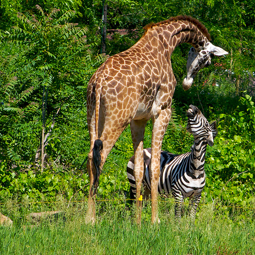

In [16]:
utils.get_thumbnail(image, pil_image=True)


In [17]:
dets = classifier.detect(image=image)
dets


[Classified<giraffe, (160.8818817138672, 32.09965515136719, 436.2586212158203, 420.6363067626953)>,
 Classified<zebra, (251.98253631591797, 215.9030990600586, 422.1377639770508, 447.78372955322266)>]

# Testing detection on the thumbnail.

In [18]:
%timeit thumb = utils.pil_thumbnail(get_thumbnail(image))

[ ] hash: /tmp/darknet/data/giraffe.jpg
[ ] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] h

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg
[X] hash : /tmp/darknet/data/giraffe.jpg
[X] 

In [19]:
get_thumbnail(image)


[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xff\x00\xff\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg


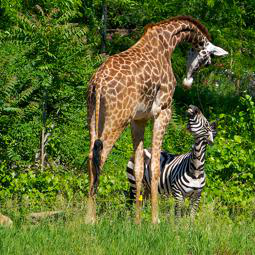

In [20]:
utils.pil_thumbnail(get_thumbnail(image))


In [21]:
thumb = utils.pil_thumbnail(get_thumbnail(image))


[X] hash : /tmp/darknet/data/giraffe.jpg
[X] thumb : /tmp/darknet/data/giraffe.jpg


In [24]:
thumb_dets = classifier.detect(thumb)

thumb_dets


[Classified<giraffe, (80.28929901123047, 9.53564453125, 224.5715103149414, 193.04086303710938)>,
 Classified<zebra, (127.68999481201172, 108.166748046875, 209.09500885009766, 225.85092163085938)>]

In [25]:
giraffe, zebra = dets
giraffe2, zebra2 = thumb_dets


In [26]:
giraffe.classification


'giraffe'

In [27]:
giraffe2.classification


'giraffe'

In [28]:
giraffe.detection.objectness


0.9837061166763306

In [29]:
giraffe2.detection.objectness


0.9933266639709473

In [31]:
np.where(np.array(giraffe.detection.prob[0 : giraffe.detection.classes]) > 0)


(array([23]),)

In [32]:
classifier.metadata.names[23]


b'giraffe'

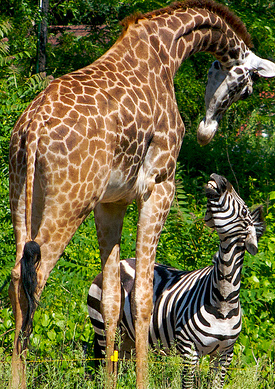

In [33]:
giraffe.crop


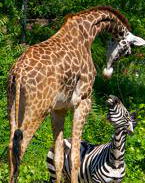

In [34]:
giraffe2.crop


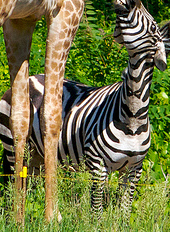

In [35]:
zebra.crop


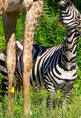

In [36]:
zebra2.crop


In [37]:
image


'/tmp/darknet/data/giraffe.jpg'

In [41]:
image_hash = redis_db.xxhash.get(image).decode()
image_hash


'4901661b1a9c69e0'

In [42]:
for det in thumb_dets:
    redis_db.objects.lpush(image_hash, det.classification)


In [44]:
redis_db.objects.lrange(start=0, end=-1, name=image_hash)


[b'zebra', b'giraffe']

In [ ]:
def get_objects(file_path, **kwargs):
    if isinstance(file_path, bytes):
        file_path = file_path.decode("UTF-8")
    file_path = str(file_path)

    file_hash = get_xxhash(file_path)

    if redis_db.thumb.exists(file_hash):
        thumb_ = redis_db.thumb.get(file_hash)
        print("[X] thumb : {}".format(file_path))
    else:
        thumb_ = utils.get_thumbnail(file_path, pil_image=False)
        redis_db.thumb.set(file_hash, thumb_)
        print("[ ] thumb : {}".format(file_path))

    return thumb_


In [45]:
redis_db.xxhash.exists(image)


True

In [48]:
file_hash = get_xxhash(image)


[X] hash : /tmp/darknet/data/giraffe.jpg


In [49]:
redis_db.objects.lrange(start=0, end=-1, name=file_hash)


[b'zebra', b'giraffe']

In [50]:
redis_db.objects.lrange(start=0, end=-1, name="foo")


[]

In [51]:
objs = redis_db.objects.lrange(start=0, end=-1, name=file_hash)
objs


[b'zebra', b'giraffe']

In [55]:
det.classification.encode("UTF-8") not in objs


False

In [56]:
if det.classification.encode("UTF-8") not in objs:
    redis_db.objects.lpush(image_hash, det.classification)
